<a href="https://colab.research.google.com/github/ArturoAntonioSotoOsornio/DMUNAM2025/blob/GutierrezAlvarezVanessa_421069158/Practica3/Pr%C3%A1ctica_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importar librerías

In [34]:
!pip install xgboost

In [59]:
!pip install imblearn

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import numpy as np

# Cargar el dataset

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
df = pd.read_csv("/content/drive/MyDrive/Practica3_Mineria/titanic.csv")

# Extraer título

El título (como Mr., Mrs., Miss, Master, Dr., Rev., etc.) puede ayudarnos a predecir una edad aproximada, además de un contexto social. Títulos como Sir, Lady, Countess están muy relacionados con la clase alta (1ra clase) que tienen una mayor probabilidad de sobrevivir

In [80]:
df['title'] = df['name'].str.extract(r',\s*([^\.]*)\s*\.', expand=False)
df['title'] = df['title'].replace(['Mlle', 'Ms'], 'Miss')
df['title'] = df['title'].replace(['Mme'], 'Mrs')
df['title'] = df['title'].replace(
    ['Capt', 'Col', 'Major', 'Dr', 'Rev', 'Jonkheer', 'Don', 'Sir', 'the Countess', 'Dona', 'Lady'],
    'Rare'
)

Nuevas variables

In [81]:
df['family_size'] = df['sibsp'] + df['parch'] + 1
df['is_alone'] = (df['family_size'] == 1).astype(int)

#Eliminar columnas irrelevantes

In [82]:
df.drop(columns=["cabin", "boat", "body", "home.dest", "ticket", "name"], inplace=True)

#Imputar valores nulos

In [83]:
df[['age', 'fare']] = SimpleImputer(strategy='median').fit_transform(df[['age', 'fare']])
df[['embarked']] = SimpleImputer(strategy='most_frequent').fit_transform(df[['embarked']])

#Codificar variables categóricas

In [84]:
# Agrupar tarifas
df['fare_bin'] = pd.cut(df['fare'], bins=[-1, 10, 30, 100, 600], labels=[0, 1, 2, 3])
df['fare_bin'] = df['fare_bin'].astype(int)

In [85]:
# Codificar variables categóricas
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['embarked'] = LabelEncoder().fit_transform(df['embarked'])
df['title'] = LabelEncoder().fit_transform(df['title'])

#Separar características (x) y etiqueta (y)

In [86]:
X = df.drop(columns='survived')
y = df['survived']

#Train y test

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Ajuste de hiperparámetros

In [90]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [91]:
param_grid = {
    'max_depth': [2, 3],
    'min_child_weight': [3, 5],
    'gamma': [0, 0.2],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5],
    'learning_rate': [0.05],
    'n_estimators': [100],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

#Entrenar modelo

In [92]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:52:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'gamma': [0, 0.2],
                         'learning_rate': [0.05], 'max_depth': [2, 3],
                         'min_child_weight': [3, 5], 'n_estimators': [100],
                         'reg_alpha': [0, 0.1], 'reg_lambda': [1, 1.5],
                         'subsample': [0.8]},
             scoring='accuracy')

#Evaluación del mejor modelo

In [93]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
validate_acc = accuracy_score(y_test, y_pred)

# Resultados
print(" Mejores hiperparámetros encontrados:", grid_search.best_params_)
print(f"\n Accuracy en entrenamiento (train): {train_acc * 100:.2f}%")
print(f" Accuracy en validación (test):     {validate_acc * 100:.2f}%")

print("\n Reporte de clasificación:\n", classification_report(y_test, y_pred))
print(" Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

 Mejores hiperparámetros encontrados: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}

 Accuracy en entrenamiento (train): 84.91%
 Accuracy en validación (test):     79.01%

 Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.77      0.89      0.82       144
           1       0.83      0.67      0.74       118

    accuracy                           0.79       262
   macro avg       0.80      0.78      0.78       262
weighted avg       0.80      0.79      0.79       262

 Matriz de confusión:
 [[128  16]
 [ 39  79]]


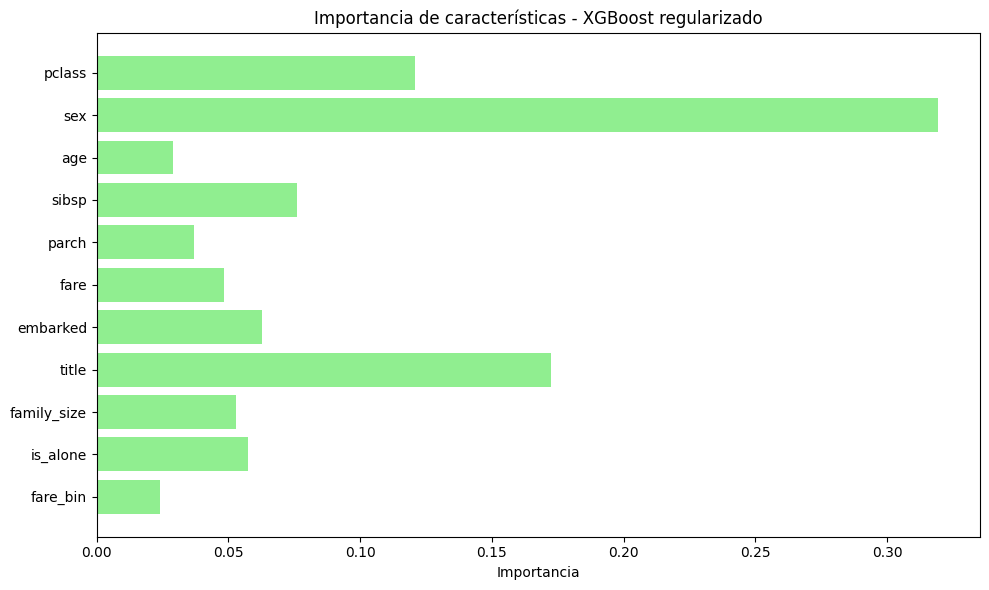

In [95]:
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color="lightgreen")
plt.xlabel("Importancia")
plt.title("Importancia de características - XGBoost regularizado")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()